In [55]:
import pywt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
import math

(512, 512)


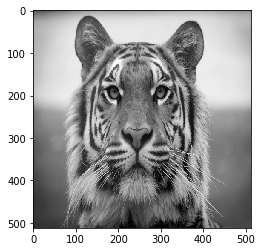

In [56]:
im = cv2.imread('08.png',0)
print(im.shape)
plt.imshow(im,cmap='gray')

# Décomposition en Ondelette

In [57]:
def histogram(array, mode='classique'):
    """Plot histogram avec normalisation par le nombre de pixel et définition de l'axe des abscisses"""
    if mode=='joli':    
        hist, bin_edges = np.histogram(array,bins=100,range=[-150,150])
    if mode == 'classique':
        hist, bin_edges = np.histogram(array,bins=100)

    plt.plot(bin_edges[1:],hist/array.size)
    plt.title(f"size of image : ({array.shape[1]},{array.shape[2]})")

In [58]:
nb_level = 3

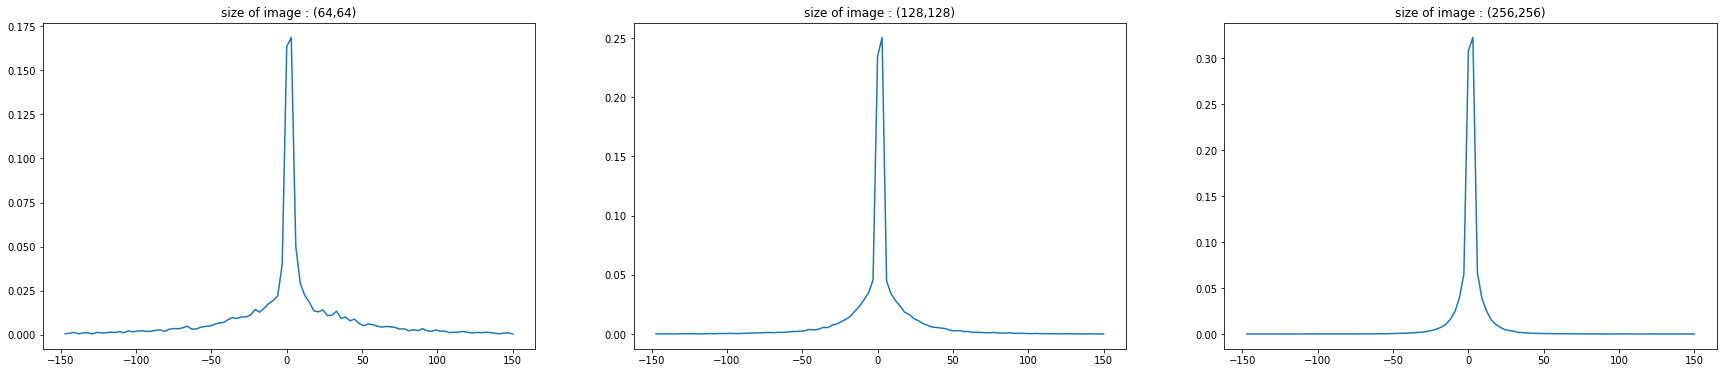

In [59]:
# compute the 2D DWT
c = pywt.wavedec2(im, 'db2',mode='periodization', level=nb_level)
arr, slices = pywt.coeffs_to_array(c)
plt.figure(figsize=(30,6))
for level in range(1,nb_level+1):
    plt.subplot(1,nb_level,level)
    histogram(np.array([c[level][0],c[level][1],c[level][2]]),'joli')

## Troncature ?

In [60]:
def filtering(array,threshold):
    return np.where((array < -threshold) | (array > threshold),0,array)

In [61]:
def troncature(array,thresholds):
    array_tronc = [array[0]]
    for level in range(1,nb_level+1):
        temp = []
        for detail in range(3):
            temp.append(filtering(array[level][detail],thresholds[level-1]))
        array_tronc.append(temp)
    return array_tronc

In [148]:
threshold = [300,150,50]
c_trcn = troncature(c,threshold)

## Quantification

In [149]:
def delta_bits(a,bits_goal,nb_level):
    """To generate the list of deltas in order to have the wanted number of bits in each level"""
    deltas = []
    for level in range(1,nb_level+1):
        temp = np.array([a[level][0],a[level][1],a[level][2]])
        val_max = 2**bits_goal[level-1]-1
        s = np.max(np.abs(temp))/val_max
        deltas.append(np.ceil(s))
    return deltas

In [150]:
def quantification(coeff,delta):

    quant = [coeff[0]]
    for level in range(1,nb_level+1):
        temp = []
        for detail in range(3):
            # temp.append(c[level][detail])
            # temp.append(np.fix(filtrage(c[level][detail],bits_goal[level-1])))
            temp.append(np.fix(coeff[level][detail])/delta[level-1])
        quant.append(temp)
    return quant 

In [151]:
# delta = [2**4,2**5,2**6]
bits_goal = [5,2,1]
delta = delta_bits(c_trcn,bits_goal,nb_level)
print(delta)
q = quantification(c_trcn,delta)

[10.0, 50.0, 1.0]


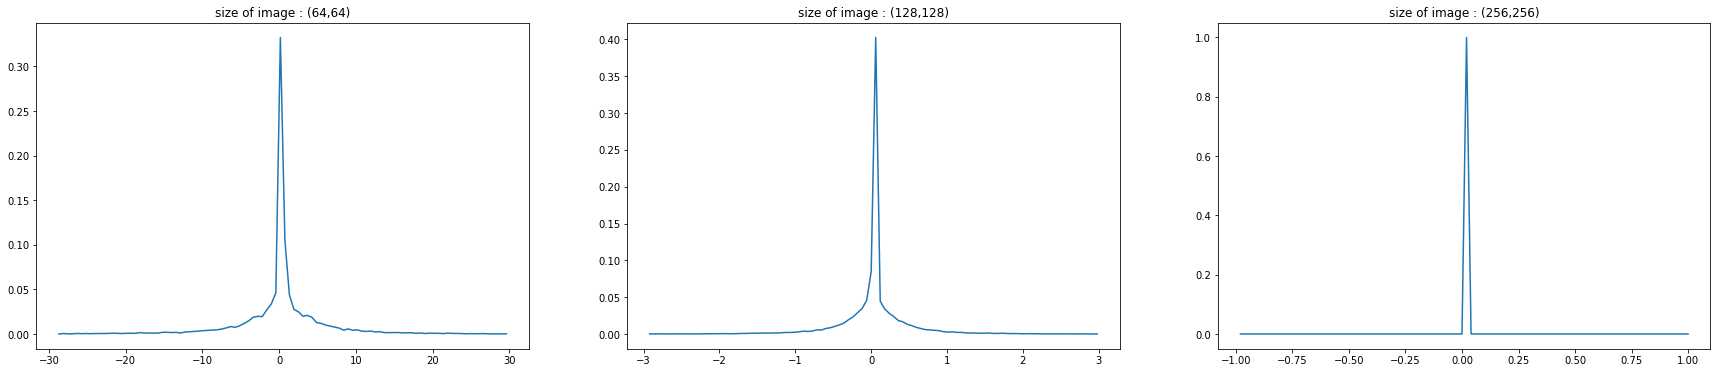

In [152]:
plt.figure(figsize=(30,6))
for level in range(1,nb_level+1):
    plt.subplot(1,nb_level,level)
    histogram(np.array([q[level][0],q[level][1],q[level][2]]))

In [153]:
def nb_bits(n):
    n_bit = math.ceil(math.log2(n))
    if n_bit>0: return n_bit
    else : return 1

In [154]:
print(nb_bits(np.max(np.abs(q[0]))))
for level in range(1,nb_level+1):
    temp = np.array([q[level][0],q[level][1],q[level][2]])
    print(nb_bits(np.max(np.abs(temp))))

11
5
2
1


## Reconstruction

In [155]:
r=0.375
c_rec = [q[0]]
for level in range(1,nb_level+1):
    temp = []
    for detail in range(3):
        temp.append(q[level][detail]*(1+r*np.sign(q[level][detail]))*delta[level-1])
    c_rec.append(temp)

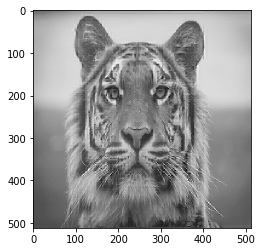

In [156]:
im_rec = pywt.waverec2(c_rec,'db2', mode='periodization')
plt.imshow(im_rec,cmap='gray')

## Mesure de l'erreur & Taux de compression

(-0.5, 511.5, 511.5, -0.5)

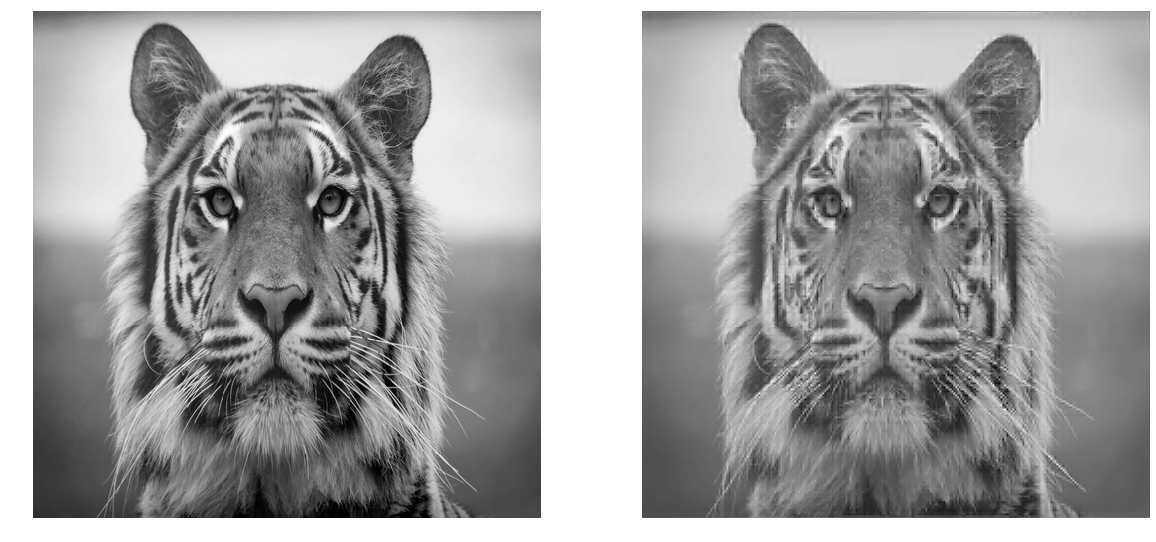

In [157]:
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(im,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(im_rec,cmap='gray')
plt.axis('off')

In [158]:
def RMSE_error(im,im_rec):
    return np.sqrt(np.mean((im-im_rec)**2))

In [161]:
def taux_comp(array_quant):
    p_ref = 8*im.size
    p_comp = array_quant[0].size*8 # Approx
    print(f"echelle {0} --> taux : {round(p_ref/p_comp)} | 0s : {np.sum(np.where(array_quant[0]==0,1,0))} | bits : {8}")
    for level in range(1,nb_level+1):
        temp = np.array([array_quant[level][0],array_quant[level][1],array_quant[level][2]])
        nb_bit_max = nb_bits(np.max(np.abs(temp)))
        if level < nb_level:
            p_comp += nb_bit_max * (temp.size)# - np.sum(np.where(temp==0,1,0)))
        print(f"echelle {level} --> taux : {round(p_ref/p_comp)} | nb_coefs : {temp.size} | bits : {nb_bit_max}")
    return p_ref/p_comp

In [162]:
print(f"RMSE Error : {RMSE_error(im_rec,im)}")
print(f"Taux de compression : {taux_comp(q)}")

RMSE Error : 12.463595181814778
echelle 0 --> taux : 64 | 0s : 0 | bits : 8
echelle 1 --> taux : 22 | nb_coefs : 12288 | bits : 5
echelle 2 --> taux : 11 | nb_coefs : 49152 | bits : 2
echelle 3 --> taux : 11 | nb_coefs : 196608 | bits : 1
Taux de compression : 10.893617021276595
